# Coding Jam 2023
## Proof of concept for an accessible navigation system
July 8 - 9 2023

### Model specifications
See Readme

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

In [2]:
from objects import Grid, Path, User, Session

In [3]:
from utils import pre_process_point, compute_haversine_distance, order_vertices, create_list_edges, create_length_edges

In [4]:
%load_ext autoreload
%autoreload 2

### Proof of concept

#### Grid

In [5]:
# Defining a toy grid
idx_to_name = {0: 'University', 1: 'Shopping center', 2: 'Gym', 3: 'Home', 4: 'Downtown', 5: 'Museum'}
name_to_idx = {name: idx for (idx, name) in idx_to_name.items()}
elevations = np.array([1, 0, 0, 4, 1, 0])
business = np.array([3, 5, 4, 1, 2, 1])
safety = np.array([5, 2, 3, 5, 3, 5])
length_edges = {(0, 1): 1, (0, 4): 2, (0, 5): 4, (1, 3): 2, (2, 3): 1, (4, 5): 3, (2, 4): 1}

In [6]:
parameters_toy_grid = {}
parameters_toy_grid['idx_to_name'] = idx_to_name
parameters_toy_grid['name_to_idx'] = name_to_idx
parameters_toy_grid['elevations'] = elevations
parameters_toy_grid['business'] = business
parameters_toy_grid['safety'] = safety
parameters_toy_grid['length_edges'] = length_edges

In [7]:
toy_grid = Grid(parameters_toy_grid)

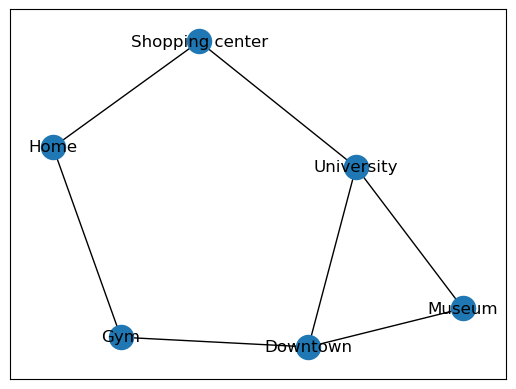

In [8]:
toy_grid.draw()

#### Path in this grid

In [9]:
path_vertices = np.array([0, 1, 3, 2])
toy_path = Path(toy_grid, path_vertices)
toy_path.is_path_correct()

True

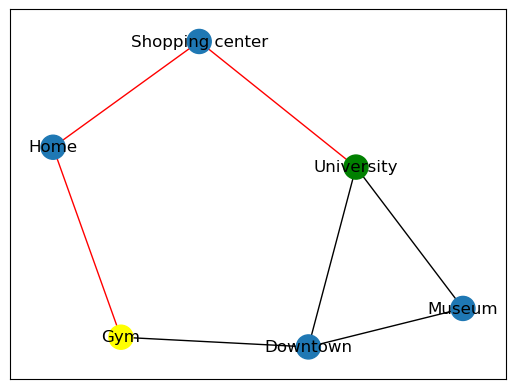

In [10]:
toy_grid.draw_path(toy_path)

#### User with no elevation concern

In [11]:
toy_user = User(coef_elevation=0, coef_business=1, coef_safety=1)

In [12]:
toy_session = Session(toy_grid, toy_user)

In [13]:
short_path = toy_session.shortest_path('Shopping center', 'Gym')

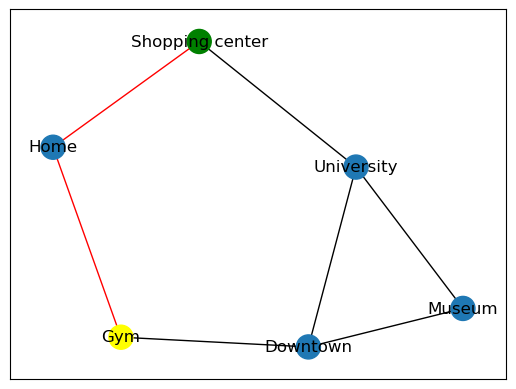

In [14]:
toy_grid.draw_path(short_path)

This user passes by home even though it is on top of a hill...

#### User trying to avoid steep slopes

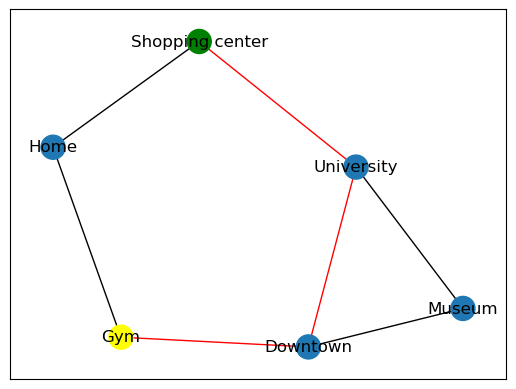

In [15]:
toy_user_avoid_elevation = User(coef_elevation=1, coef_business=0, coef_safety=0)
toy_session_avoid_elevation = Session(toy_grid, toy_user_avoid_elevation)
short_path_avoid_elevation = toy_session_avoid_elevation.shortest_path('Shopping center', 'Gym')
toy_grid.draw_path(short_path_avoid_elevation)

This new user is particularly sensitive to changes in elevation and not so much to any crowdedness of safety issues on their way. Hence they don't by home to go from shopping center to gym.

### Gathering real-life data

#### San Francisco street network data

In [16]:
raw_data = pd.read_csv('data/sf_street_network.csv')

In [17]:
raw_data.head()

,cnn,st_name,st_type,cnntext,the_geom
0,51126000,LIEBIG,ST,51126000,POINT (-122.45527873980747 37.707912301522924)
1,33704000,RHINE,ST,33704000,POINT (-122.46231335632307 37.70798826011384)
2,25323000,POLLARD,PL,25323000,POINT (-122.40642965120786 37.79887233945914)
3,27999000,44TH,AVE,27999000,POINT (-122.50522585724966 37.781076643928415)
4,21174000,HARRISON,ST,21174000,POINT (-122.41159284436014 37.749436231246975)


**cnn** (same as **cnntext**) is a unique identifier associated to a node (intersection between two streets) in San Francisco. The geographic coordinates of those nodes are provided in the column **the_geom**. One of the streets passing by the node is described in columns **st_name** and **st_type**. Hence it is natural that there are more rows in this dataframe (18,511) than actual intersections (9,696).

#### Testing some auxiliary functions

In [18]:
# Example of Haversine distance between the two first points
compute_haversine_distance([-122.45527873980747, 37.707912301522924], (-122.46231335632307, 37.70798826011384))

618.8971171490089

#### Data pre-processing to match our format

In [20]:
nodes = raw_data['cnn'].unique()

In [21]:
idx_to_name = {i: nodes[i] for i in range(len(nodes))}
name_to_idx = {name: idx for (idx, name) in idx_to_name.items()}

In [22]:
coordinates = raw_data.drop_duplicates('cnn').set_index('cnn')[['the_geom']].applymap(pre_process_point).loc[nodes].values
coordinates = {nodes[i]: coordinates[i][0] for i in range(len(nodes))}

In [23]:
list_edges = create_list_edges(raw_data, coordinates)

In [24]:
length_edges = create_length_edges(list_edges, coordinates, name_to_idx)

In [31]:
# No data for now on elevations, crowdedness and safety
elevations = np.zeros(len(nodes))
business = np.zeros(len(nodes))
safety = np.zeros(len(nodes))

In [26]:
parameters_grid = {}
parameters_grid['idx_to_name'] = idx_to_name
parameters_grid['name_to_idx'] = name_to_idx
parameters_grid['elevations'] = elevations
parameters_grid['business'] = business
parameters_grid['safety'] = safety
parameters_grid['length_edges'] = length_edges

In [ ]:
grid = Grid(parameters_grid)

In [ ]:
grid.draw()

### Sources
- https://data.sfgov.org/Geographic-Locations-and-Boundaries/Street-Intersections/gmfx-8h6i/data?no_mobile=true
- https://datasf.gitbook.io/draft-publishing-standards/standard-reference-data/basemap/street-centerlines-nodes
- https://en.wikipedia.org/wiki/Haversine_formula

### Future work

Elevation data for San Francisco is available on https://data.sfgov.org/Energy-and-Environment/Elevation-Contours/rnbg-2qxw, in the form of elevation contours, and further preprocessing would be required to compute the elevation on each intersection between streets. In a less precise fashion, it appears that some databases are able to approximate the altitude of a point in space given its coordinates only, but in a zone such as San Francisco with multiple hills, it is obvious that the use of such tools would prove very limited.

Regarding the safety index, we are suggesting to leverage the crime data for each neighborhood, available at https://www.civichub.us/ca/san-francisco/gov/police-department/crime-data/neighborhoods. Once again, further preprocessing would be needed to map each node of the graph to a neighborhood and a corresponding safety index.

As far as crowdedness is concerned, we were not able to find any promising dataset for the city of San Francisco. Some rough estimations based om touristic areas could be in order.